<a href="https://colab.research.google.com/github/lakshitgosain/Tensorflow-ZTM/blob/main/TF_ZTM_05_TransferLearning_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow Part 2: Fine Tuning



In [1]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-06-02 08:52:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-02 08:52:47 (77.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Let's get some data

This time we're going to see how we can use the pre-trained models within tf.keras.applications and apply them to our own problem



Get the 10% Foor dataset

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-06-02 08:52:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 172.253.114.128, 172.253.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   193MB/s    in 0.8s    

2023-06-02 08:52:52 (193 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [4]:
# Create training and test direcotry paths

train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [5]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=IMG_SIZE,
    label_mode='categorical',
    batch_size=BATCH_SIZE,

)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                              image_size=IMG_SIZE,
                                                              label_mode='categorical',
                                                              batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
train_data_10_percent # NONE is insterted due to the batch sie

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [7]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [8]:
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[134.15816    134.15816    144.15816   ]
   [134.14287    136.92857    146.        ]
   [131.57143    136.21428    147.        ]
   ...
   [163.08691    130.5052     143.36752   ]
   [158.02556    127.311325   145.38277   ]
   [159.17345    137.37251    157.37247   ]]

  [[130.7347     132.52551    141.92857   ]
   [118.122444   121.98469    130.9847    ]
   [123.255104   130.08673    140.14285   ]
   ...
   [171.16835    138.55606    149.11224   ]
   [171.71428    137.86224    154.00513   ]
   [166.10713    136.1072     154.17862   ]]

  [[122.87245    126.591835   135.59183   ]
   [121.561226   128.34694    136.84694   ]
   [122.43368    131.05101    140.81633   ]
   ...
   [169.82733    135.77621    142.51604   ]
   [182.06125    139.80104    151.38777   ]
   [207.76604    164.48033    178.05176   ]]

  ...

  [[ 96.658165    63.642857    70.290855  ]
   [ 81.75513     54.07149     58.928658  ]
   [ 38.07145     17.668371    21.520462  ]
   ...
   [ 40.356903    31.356

Keras Sequential vs FUnctional API

* Functional API is more flexible

## Model 0 : Building a transfer learning feature extraction model with Functional API

The sequential API is straight forward, but the functional API Gives us more flexibility with our models

In [9]:
#1. Create the base model with tf.keras.applications

base_model=tf.keras.applications.EfficientNetB0(
    include_top=False,

)

# 2. Freeze the base model(the underlying pre-trained patterns aren't modified )

base_model.trainable=False

#3. Create the input into our odel
inputs =  tf.keras.layers.Input(shape=(224,224,3), name='Input layer')

#4. If using Resnet50V2 you will need to normalize inputs
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. pass the inputs to the base_model
x=base_model(inputs)
print(f"shape after passing inputs to our base model{x.shape}")

#6. Average pool the outputs of the base model(aggregate all the most importantinformation)
x=tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"shape after global averagepooling2D:{x.shape}")

#7. Create the otput activation layer
outputs=tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

#8 Comibe the inputs with the outputs into a model
model_0=tf.keras.Model(inputs, outputs)

#9 Compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)
#10. Fit the model and save it's history
istory_10_percent= model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name='10_percent')])




16705208/16705208 [==============================] - 0s 0us/step


shape after passing inputs to our base model(None, 7, 7, 1280)
shape after global averagepooling2D:(None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent/20230602-085303
Epoch 1/5
24/24 [==============================] - 28s 230ms/step - loss: 1.8337 - accuracy: 0.4547 - val_loss: 1.2661 - val_accuracy: 0.7516
Epoch 2/5
24/24 [==============================] - 4s 135ms/step - loss: 1.0749 - accuracy: 0.7680 - val_loss: 0.8460 - val_accuracy: 0.8224
Epoch 3/5
24/24 [==============================] - 5s 177ms/step - loss: 0.7751 - accuracy: 0.8320 - val_loss: 0.6780 - val_accuracy: 0.8289
Epoch 4/5
24/24 [==============================] - 5s 175ms/step - loss: 0.6336 - accuracy: 0.8560 - val_loss: 0.6061 - val_accuracy: 0.8322
Epoch 5/5
24/24 [==============================] - 5s 177ms/step - loss: 0.5376 - accuracy: 0.8733 - val_loss: 0.5201 - val_accuracy: 0.8668


In [10]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.5514 - accuracy: 0.8592


[0.5514237880706787, 0.8592000007629395]

In [11]:
#Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7fd2e3886830>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd2e3768a90>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7fd2e39381c0>
3 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fd2e39389d0>
4 <keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fd2e39392a0>
5 <keras.layers.convolutional.conv2d.Conv2D object at 0x7fd2e393a140>
6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd2e39393c0>
7 <keras.layers.core.activation.Activation object at 0x7fd2e393af50>
8 <keras.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x7fd2e393ba30>
9 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fd2e36ed5d0>
10 <keras.layers.core.activation.Activation object at 0x7fd2e36ee6e0>
11 <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fd2e36ee770>
12 <keras.l

In [12]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

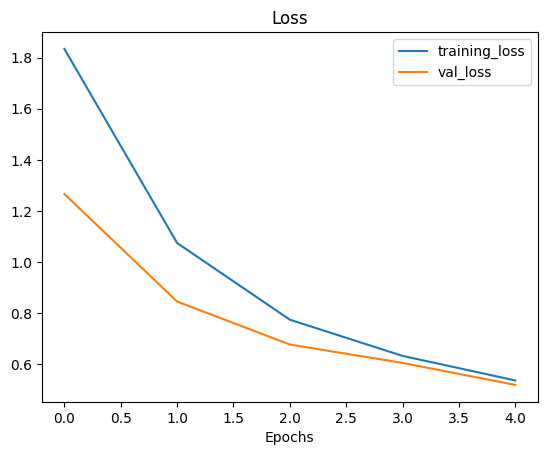

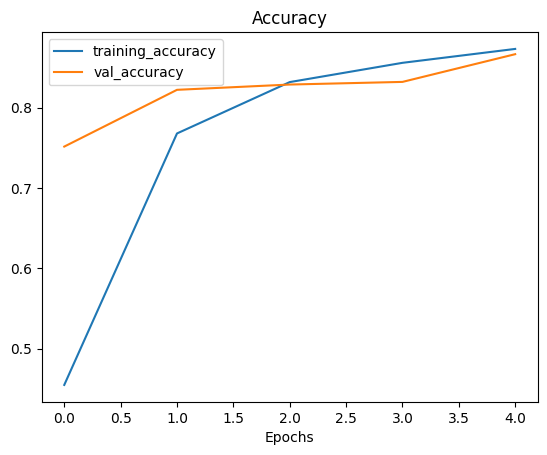

In [14]:
plot_loss_curves(istory_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.

We have a ensor after our model goes through 'base model' of shape (None, 7,7 , 1280).

But then it passes through GlobalAveragePooling2D, it turns into (None,1280).

let's use a similar shaped tensor (1,4,4,2) and the pass it through GlobalAverage2D.


In [15]:
input_shape=(1,4,4,3)

#Create a Random Tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)

print("Random Input Tensor {}".format(input_tensor))



Random Input Tensor [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]


In [16]:
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

In [17]:
print(global_average_pooled_tensor)

tf.Tensor([[-0.09368646 -0.45840448 -0.2885598 ]], shape=(1, 3), dtype=float32)


In [18]:
print(f"Shape of input tensor{input_tensor.shape} and shapeof averagePooled Tensor{global_average_pooled_tensor.shape}")

Shape of input tensor(1, 4, 4, 3) and shapeof averagePooled Tensor(1, 3)


This is the input to the Output layer

One of the reasons feature extraction transfer learning is named how it is is because what happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of the model on a particular sample , in our case this is the output of tf.keras.layers.GlobalAveragePooling2D layer which can be then used to extract patterns out of for our own specific problem)

## Running a series of transfer learning experiments

We've seen the incredible results Transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...how about we setup a bunch of experiments to find out

1. 'model_1' - use feature extraction transfer learning with 1% of the training data with data augmentation.
2. 'mode_2' - use feature extraction transfer learning with 10& of the training data with data aith data augmentation

3. 'model_3' - use fine tuning transfer learning with 10% of the training data with Data Augmentation

4. 'model_4'- use fin-tuning transfer learning on 100% of the training data with data augmentation.



## Getting and preprocessing data for model_1

In [19]:
# Download and unzip data 

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2023-06-02 08:54:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   156MB/s    in 0.8s    

2023-06-02 08:54:05 (156 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
unzip_data("10_food_classes_1_percent.zip")

In [21]:
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [22]:
#How many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There a

In [23]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                               image_size=IMG_SIZE,
                                                                               batch_size=BATCH_SIZE,
                                                                               label_mode='categorical')

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=IMG_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              label_mode='categorical')

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data Augmentation right into the model

TO add data augmentation into our models, we can use the layers inside:

* tf.keras.layers.experimental.preprocessing()

The benifits of using Data Augmentatio inside the model:
* Preprocessing of images (Augmenting them happens in the GPU)
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation with horizontal flipping, rotations, zooms etc

data_augmentations= keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) #Keep for models lile Resnet50V2 but EfficientNet has already built in
], name="data_augmentations")

### Vizualize our data Augmentation Layer and see what happens to our data

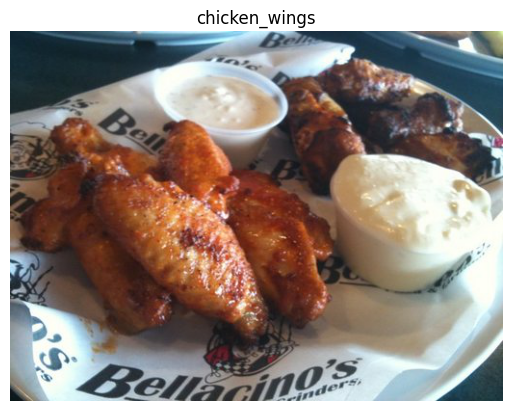

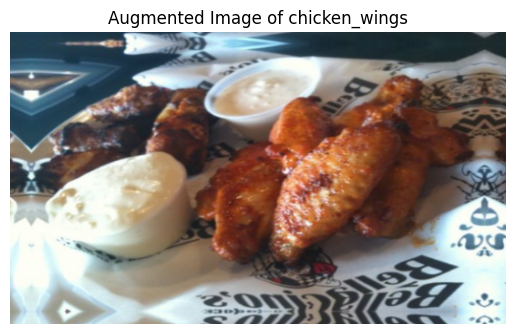

In [25]:
#View a Random Image and compare it to it's augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/" +target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+"/"+ random_image

#Read in the random image
img=mpimg.imread(random_image_path)
plt.title(target_class)
plt.axis(False)
plt.imshow(img);

#Now we want to augment that 
augmented_image=data_augmentations(tf.expand_dims(img,axis=0))
plt.figure()
plt.title(f"Augmented Image of {target_class}")
plt.axis(False)
plt.imshow(tf.squeeze(augmented_image)/255.)

## Model_1: 

In [28]:
#Setup input shape and the base model, freeze the model layers
input_shape=(224,224,3)
IMG_SIZE + (3,)

(224, 224, 3)

In [33]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create input layers
inputs=layers.Input(shape=input_shape,
                    name='input layer')

#Add in Data Augmentation Sequential model as a layer

x= data_augmentations(inputs)

#Give base model the inputs after they have been augmented and dont train it
x= base_model(x, training=False)

#Pool output features of the base model
x=layers.GlobalAveragePooling2D()(x)

#Put a Dense layer on as a output
outputs=layers.Dense(10,activation='softmax', name='output_layer')(x)

#Make a model using the inputs and outputs
model_1=keras.Model(inputs,outputs)

#Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_1_percent=model_1.fit(train_data_1_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_1_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25*len(test_data)),
                              callbacks=[create_tensorboard_callback("transfer_learning",
                                                                     experiment_name='1_percent_data_extraction')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_extraction/20230602-090720
Epoch 1/5
3/3 [==============================] - 13s 3s/step - loss: 2.3124 - accuracy: 0.1571 - val_loss: 2.2044 - val_accuracy: 0.1727
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1067 - accuracy: 0.2429 - val_loss: 2.0828 - val_accuracy: 0.2845
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.8743 - accuracy: 0.4429 - val_loss: 1.9539 - val_accuracy: 0.3783
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.6962 - accuracy: 0.5857 - val_loss: 1.8458 - val_accuracy: 0.4474
Epoch 5/5
3/3 [==============================] - 5s 2s/step - loss: 1.5676 - accuracy: 0.6429 - val_loss: 1.7594 - val_accuracy: 0.5033


In [35]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentations (Sequent  (None, None, None, 3)    0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [36]:
results_1_percent_data_aug=model_1.evaluate(test_data)

79/79 [==============================] - 8s 86ms/step - loss: 1.7497 - accuracy: 0.5080


How do thr model with 1 % of the data and data augmentation loss curves look like

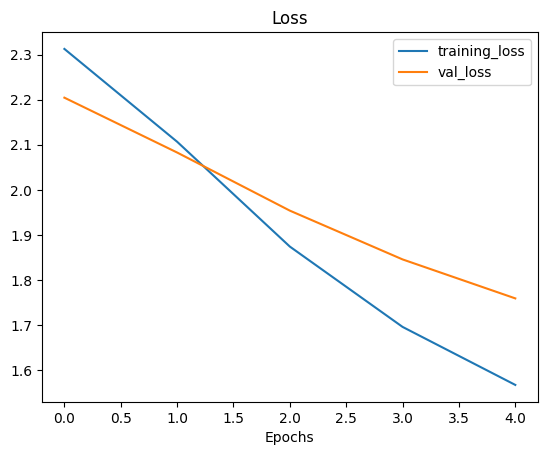

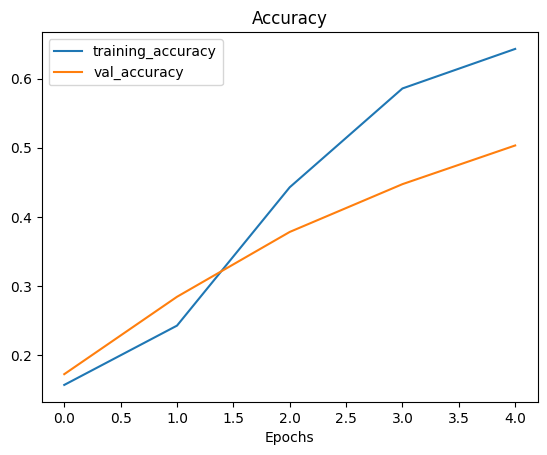

In [37]:
plot_loss_curves(history_1_percent)

## Model_2

In [38]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-06-02 09:11:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.182.128, 64.233.183.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   151MB/s    in 1.1s    

2023-06-02 09:11:18 (151 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [39]:
train_dir_10_percent="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [41]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [40]:
IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode='categorical',
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode='categorical',
                                                              image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [43]:
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentations=Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
])


In [44]:
input_shape=(224,224,3)

In [51]:
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs=layers.Input(shape=input_shape,
                    name="Input layer")

x=data_augmentations(inputs)

x=base_model(x,training=False)#pass augmented images to base model but keep it in inference mode, this also ensures batchnorm layers dont get updated
#BatchNorm is the only layer that shouldn't be unfrozen during re-training
x=layers.GlobalAveragePooling2D()(x)

outputs=layers.Dense(10, activation='softmax',name='output_layer')(x)

model_2=keras.Model(inputs,outputs)

model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.fit(train_data_10_percent,
            steps_per_epoch=len(train_data_10_percent),
                                epochs=5,
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback('transfer_learning',
                                                                       experiment_name='10_percent_data_aug')])


                                 

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230602-094454
Epoch 1/5
24/24 [==============================] - 22s 587ms/step - loss: 2.0217 - accuracy: 0.3533 - val_loss: 1.4619 - val_accuracy: 0.6842
Epoch 2/5
24/24 [==============================] - 10s 388ms/step - loss: 1.3255 - accuracy: 0.6880 - val_loss: 1.0028 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - 10s 411ms/step - loss: 1.0196 - accuracy: 0.7453 - val_loss: 0.7765 - val_accuracy: 0.8322
Epoch 4/5
24/24 [==============================] - 10s 380ms/step - loss: 0.8360 - accuracy: 0.8040 - val_loss: 0.6907 - val_accuracy: 0.8454
Epoch 5/5
24/24 [==============================] - 10s 388ms/step - loss: 0.7380 - accuracy: 0.8213 - val_loss: 0.5863 - val_accuracy: 0.8635


In [49]:
model_2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

### Creating a Model Checkpoint callback

The modelCheckpoint callback intermediately saves outr model( the full model or just the weights) during training. 

In [52]:
checkpoint_path='ten_percent_model_checkpoints_weights/checkpoint.ckpt'

#Create a modelCheckPoint Callback that saves the model's weights only

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_best_only=False,
                                                       save_weights_only=True,
                                                       save_freq='epoch', #Saves every Epoch
                                                       verbose=1
                                                       )

In [70]:
model_2.fit(train_data_10_percent,
            steps_per_epoch=len(train_data_10_percent),
                                epochs=5,
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback('transfer_learning',
                                                                       experiment_name='10_percent_data_aug'),
                                           checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230602-101414
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.9373
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 348ms/step - loss: 0.2882 - accuracy: 0.9373 - val_loss: 0.4405 - val_accuracy: 0.8717
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.9387
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 474ms/step - loss: 0.2881 - accuracy: 0.9387 - val_loss: 0.4264 - val_accuracy: 0.8701
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9453
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 303ms/step - loss: 0.2685 - accuracy: 0.9453 - val_loss: 0.3911 - val_accuracy: 0.8914
Epo

In [61]:
initial_epochs=5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                               epochs=initial_epochs,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback("transfer_learning",
                                                                      experiment_name="10_percent_data_aug"),
                                         checkpoint_callback ])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230602-100207
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.9133
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 355ms/step - loss: 0.3561 - accuracy: 0.9133 - val_loss: 0.4291 - val_accuracy: 0.8701
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.9187
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 333ms/step - loss: 0.3412 - accuracy: 0.9187 - val_loss: 0.4049 - val_accuracy: 0.8799
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.9307
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 320ms/step - loss: 0.3445 - accuracy: 0.9307 - val_loss: 0.4518 - val_accuracy: 0.8701
Epoc

In [71]:
results_10_percent_data_aug=model_2.evaluate(test_data)

79/79 [==============================] - 6s 65ms/step - loss: 0.4204 - accuracy: 0.8728


In [58]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 65ms/step - loss: 0.5514 - accuracy: 0.8592


[0.5514237880706787, 0.8592000007629395]

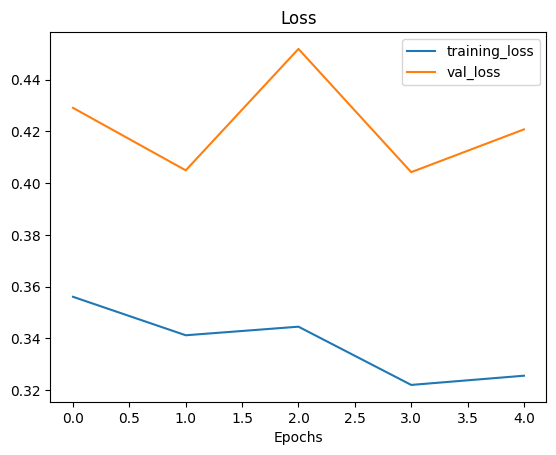

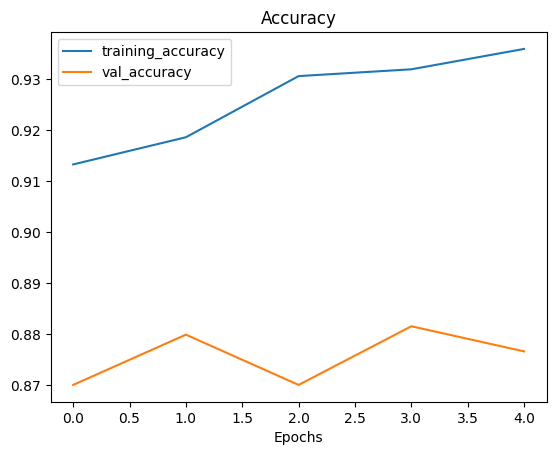

In [62]:
plot_loss_curves(history_10_percent_data_aug)

In [63]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
____________________________________________

### Loading in checkpointed weights

Returns a model to a specific checkpoint

In [72]:
#load in saved model weights and evaluate

model_2.load_weights(checkpoint_path)

In [73]:
#Evaluate the model with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.4204 - accuracy: 0.8728


In [74]:
#If the results from our previouly evaluated model match, then everything is fine and working
results_10_percent_data_aug==loaded_weights_model_results

False

In [75]:
loaded_weights_model_results,results_10_percent_data_aug

([0.4203900992870331, 0.8727999925613403],
 [0.42038998007774353, 0.8727999925613403])

In [77]:
# precision of the numbers stored is different
#Check to see if loaded model results are very close to the previous non loaded results

import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])